In [107]:
import papyrus_scripts
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import numpy as np
from matplotlib.patches import Patch

from rdkit import Chem
from rdkit import RDConfig
from rdkit import DataStructs
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdMolHash
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.ML.Cluster import Butina
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize=(450,350)
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdqueries
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)

from IPython.display import SVG,Image
from ipywidgets import interact

import rdkit

from mutant_analysis_protein import calculate_average_residue_distance_to_ligand

In [108]:
# Define directories and protein of interest
output_dir = 'C:\\Users\\gorostiolam\\Documents\\Gorostiola Gonzalez, ' \
             'Marina\\PROJECTS\\6_Mutants_PCM\DATA\\2_Analysis\\0_mutant_statistics'
preferred_common_subset_dir = 'common_subset_20_sim_80'
# Targets with most data: P00533, P00519, P36888, Q72547
target_ids = ['Q72547']
accession = target_ids[0]

<>:3: DeprecationWarning: invalid escape sequence \D
<>:3: DeprecationWarning: invalid escape sequence \D
<>:3: DeprecationWarning: invalid escape sequence \D
C:\Users\gorostiolam\AppData\Local\Temp\ipykernel_12100\1134267423.py:3: DeprecationWarning: invalid escape sequence \D
  'Marina\\PROJECTS\\6_Mutants_PCM\DATA\\2_Analysis\\0_mutant_statistics'


In [109]:
def read_annotated_combined_data(accession):
    """
    Read mutant-annotated data from ChEMBL and Papyrus. Filter for an accession of interest.
    :param accession:
    :return:
    """
    data = pd.read_csv('C:\\Users\\gorostiolam\\Documents\\Gorostiola Gonzalez, '
                       'Marina\\PROJECTS\\6_Mutants_PCM\\PROTOCOLS-SCRIPTS\\Python\\mutants-in-pcm\\data\\chembl31'
                       '-annotated_papyrus05.5nostereo_data_with_mutants.csv', sep='\t')

    accession_data = data[data['accession'] == accession]

    return accession_data

In [110]:
# Mutant-annotated data from ChEMBL + Papyrus for an accession of interest
accession_data = read_annotated_combined_data(accession)
accession_data

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  


,CID,connectivity,target_id,AID,accession,pchembl_value_Mean,SMILES,sequence,source,Activity_class,Year
47240,CHEMBL4263348,KXAGAFWODPZSHZ,Q72547_A502F,"[1791429, 1791429, 1791429, 1791429]",Q72547,5.102500,COc1cc(N2CCCC2)c(OC)cc1/C=C1/NC(=O)NC1=O,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,ChEMBL31,NaN,2018.0
47241,CHEMBL693547,JIYRSPUMGRIYBL,Q72547_A98G,"[79618, 79618, 79618]",Q72547,5.376667,Cc1cccc2c1nc(-c1c(F)cccc1F)n2Cc1c(F)cccc1F,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,ChEMBL31,NaN,1997.0
47242,CHEMBL695506,AMLBAOPYPUXEQF,Q72547_A98G,[79632],Q72547,4.750000,Fc1cccc(F)c1C1SCc2nc3ccccc3n21,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,ChEMBL31,NaN,1997.0
47243,CHEMBL4021679,XHRNTQCVULTCLC,Q72547_E138K,"[1671650, 1671650, 1671650, 1671650, 1671650, ...",Q72547,8.181667,COCCOC(=O)c1cc(N)c(Nc2ccc(C#N)cc2)cc1Oc1c(C)cc...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,ChEMBL31,NaN,2017.0
47244,CHEMBL4038741,JQVAMZLIRTYPAD,Q72547_E138K,"[1688171, 1688171, 1688171, 1688171, 1688171, ...",Q72547,6.289444,N#Cc1ccc(Nc2nccc(OCc3cccc(Br)c3)n2)cc1,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,ChEMBL31,NaN,2017.0
...,...,...,...,...,...,...,...,...,...,...,...
48252,CHEMBL802404,HHTVAFPSLHBBQG,Q72547_Y188L,"[195366, 195366, 195366, 195366, 195366, 19536...",Q72547,6.133333,CCN1c2ncc(CSc3[nH]cnc4nncc3-4)cc2C(=O)N(C)c2cc...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,ChEMBL31,NaN,1998.0
48253,CHEMBL802994,CAGLBGYLRFBUID,Q72547_Y188L,"[196190, 196190, 196190, 196190, 196190, 19619...",Q72547,6.127333,O=c1c2cccn2c2cccc(F)c2n1CC/N=C(\S)Nc1ccc(Br)cn1,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,ChEMBL31,NaN,2001.0
48254,CHEMBL871579,HBOMLICNUCNMMY,Q72547_Y188L,"[373032, 373032]",Q72547,7.520000,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,ChEMBL31,NaN,2006.0
48255,CHEMBL900572,ARRLMRHYVRHARM,Q72547_Y188L,"[450291, 450291, 450291, 450291, 450291, 45029...",Q72547,5.433529,CN(C)c1nc(Cc2c(F)cccc2F)cc(=O)[nH]1,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,ChEMBL31,NaN,2007.0


In [111]:
# All molecules that have been tested in the target of interest
accession_subset = accession_data['connectivity'].unique().tolist()

In [112]:
def read_common_subset(accession: str, common: bool, sim: bool, sim_thres: int,
                                           threshold: int, variant_coverage: float, output_dir: str):
    # Read bioactivity data for common subset precalculated
    data_common = pd.read_csv(os.path.join(output_dir, f'modelling_dataset_{accession}_Thr{threshold}_Cov'
                                                          f'{int(variant_coverage*100)}_Sim'
                                                          f'{int(sim_thres*100)}.csv'), sep='\t')

    return data_common

def extract_unique_connectivity(data):
    common_subset = data['connectivity'].unique().tolist()
    return common_subset

In [113]:
# Molecules in the defined "common subset" across variants
common_subset = extract_unique_connectivity(read_common_subset(accession, common=True, sim=True, sim_thres=0.8,
                                                            threshold=2, variant_coverage=0.2, output_dir=os.path
                                                               .join(output_dir,preferred_common_subset_dir)))

In [114]:
# For reference, just Papyrus data
def filter_explore_activity_data(papyrus_version, target_accession_list):
    """
    Filter Papyrus dataset for targets of interest and explore the statistics of the resulting dataset

    Parameters
    ----------
    papyrus_version : str
        Version of the Papyrus dataset to read
    targets : dict
        Dictionary with target labels as keys and UniProt accession codes as values

    Returns
    -------
    pandas.DataFrame
        Filtered bioactivity dataset for input targets
    """
    # Read downloaded Papyrus dataset in chunks, as it does not fit in memory
    CHUNKSIZE = 100000
    data = papyrus_scripts.read_papyrus(
        version=papyrus_version, chunksize=CHUNKSIZE)

    # Create filter for targets of interest
    filter = papyrus_scripts.keep_accession(data, target_accession_list)

    # Iterate through chunks and apply the filter defined
    filtered_data = papyrus_scripts.preprocess.consume_chunks(
        filter,
        total=-(
            -papyrus_scripts.utils.IO.get_num_rows_in_file("bioactivities", False) // CHUNKSIZE
        ),
    )

    # Plot distribution of activity values (pchembl_value_Mean) per target
    g = sns.displot(
        filtered_data,
        x="pchembl_value_Mean",
        hue="target_id",
        element="step"
    )

    return filtered_data

  0%|          | 0/13 [00:00<?, ?it/s]

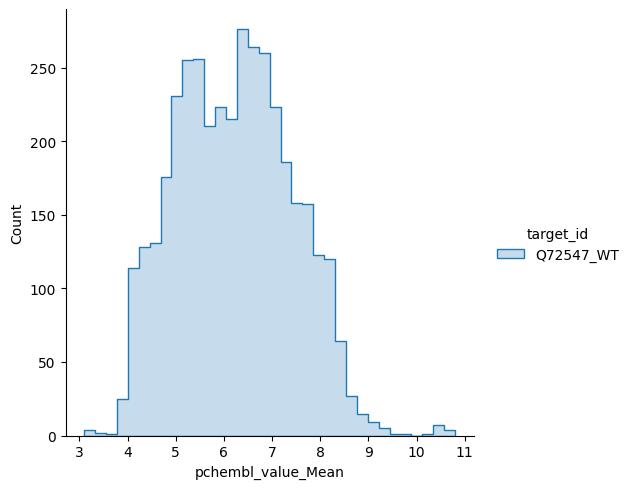

In [115]:
papyrus_accession_data = filter_explore_activity_data('05.5', target_ids)

In [116]:
papyrus_accession_data

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,type_KD,type_Ki,relation,pchembl_value,pchembl_value_Mean,pchembl_value_StdDev,pchembl_value_SEM,pchembl_value_N,pchembl_value_Median,pchembl_value_MAD
168,AACCNNVWDGCWLI_on_Q72547_WT,High,ChEMBL30,CHEMBL2337176,O=c1ccn(CCOc2ccc(F)cc2)c(=O)n1Cc1ccccc1,AACCNNVWDGCWLI,AACCNNVWDGCWLI-UHFFFAOYSA-N,InChI=1S/C19H17FN2O3/c20-16-6-8-17(9-7-16)25-1...,"""AuxInfo=1/0/N:23,22,24,21,25,11,14,10,15,3,4,...",Q72547_WT,...,0;1,1;0,=,4.15;4.15,4.150000,0.000000,0.000000,2.0,4.15,0.00
337,AAEGSDHYBKABPZ_on_Q72547_WT,High,ChEMBL30,CHEMBL4168270,O=c1[nH]c2c(c(=O)n1O)C1CCCCC1S2,AAEGSDHYBKABPZ,AAEGSDHYBKABPZ-UHFFFAOYSA-N,InChI=1S/C10H12N2O3S/c13-9-7-5-3-1-2-4-6(5)16-...,"""AuxInfo=1/1/N:12,13,11,14,10,15,5,4,6,2,3,8,7...",Q72547_WT,...,0;1,1;0,=,7.0;7.0,7.000000,0.000000,0.000000,2.0,7.00,0.00
432,AAFPOXVSABYSQW_on_Q72547_WT,High,ChEMBL30,CHEMBL1172577,COC(=O)C(C)NP(=O)(OCC1C=CC(n2cc(C#CCOCCOCCOCCO...,AAFPOXVSABYSQW,AAFPOXVSABYSQW-UHFFFAOYSA-N,InChI=1S/C46H56BrN6O14PS/c1-32-7-10-37(11-8-32...,"""AuxInfo=1/1/N:67,6,40,1,20,19,65,68,51,64,69,...",Q72547_WT,...,0;1,1;0,=,5.64;5.64,5.640000,0.000000,0.000000,2.0,5.64,0.00
545,AAHQTPLPZUWINV_on_Q72547_WT,High,ChEMBL30,CHEMBL401592,CC(C)c1c(Cl)n(C)c(=NS(=O)(=O)c2cc(C#N)ccc2C#N)s1,AAHQTPLPZUWINV,AAHQTPLPZUWINV-UHFFFAOYSA-N,InChI=1S/C15H13ClN4O2S2/c1-9(2)13-14(16)20(3)1...,"""AuxInfo=1/0/N:1,3,8,19,20,15,17,22,2,16,21,14...",Q72547_WT,...,0;1,1;0,=,5.52;5.52,5.520000,0.000000,0.000000,2.0,5.52,0.00
591,AAIRSTHTASQCBC_on_Q72547_WT,High,ChEMBL30,CHEMBL1801226,N#Cc1cc(Oc2cc(OCc3cc(-c4ccccc4)no3)ccc2Cl)cc(C...,AAIRSTHTASQCBC,AAIRSTHTASQCBC-UHFFFAOYSA-N,InChI=1S/C23H14Cl2N2O3/c24-17-8-15(13-26)9-19(...,"""AuxInfo=1/0/N:18,17,19,16,20,23,24,30,4,27,13...",Q72547_WT,...,0;0;0;0;0;0;0;1;1;1,0;0;0;0;1;1;1;0;0;0,=,6.94;6.94;6.94;6.94;6.12;6.94;7.51;6.12;6.94;7.51,6.890000,0.467808,0.147934,10.0,6.94,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236748,ZZEPINNNVYAVRO_on_Q72547_WT,High,ChEMBL30,CHEMBL1642765,CC(C)OC(=O)COC(=O)c1ccc([N+](=O)[O-])o1,ZZEPINNNVYAVRO,ZZEPINNNVYAVRO-UHFFFAOYSA-N,InChI=1S/C10H11NO7/c1-6(2)17-9(12)5-16-10(13)7...,"""AuxInfo=1/0/N:1,3,12,13,7,2,11,14,5,9,15,6,10...",Q72547_WT,...,0;1,1;0,=,4.88;4.88,4.880000,0.000000,0.000000,2.0,4.88,0.00
1236947,ZZHHENIDJUGTSZ_on_Q72547_WT,High,ChEMBL30,CHEMBL1078057,NS(=O)(=O)c1ccc(NC(=O)CCC(=O)N2CCCc3cc(Cl)cc(C...,ZZHHENIDJUGTSZ,ZZHHENIDJUGTSZ-UHFFFAOYSA-N,InChI=1S/C19H18Cl3N3O4S/c20-12-8-11-2-1-7-25(1...,"""AuxInfo=1/1/N:18,19,6,7,12,13,17,21,24,30,20,...",Q72547_WT,...,0;1,1;0,=,6.71;6.71,6.710000,0.000000,0.000000,2.0,6.71,0.00
1237347,ZZLXDVUVHCYMNY_on_Q72547_WT,High,ChEMBL30,CHEMBL4065015,N#Cc1ccc(Nc2nc(OCc3cccc(F)c3)ccn2)cc1,ZZLXDVUVHCYMNY,ZZLXDVUVHCYMNY-UHFFFAOYSA-N,InChI=1S/C18H13FN4O/c19-15-3-1-2-14(10-15)12-2...,"""AuxInfo=1/1/N:15,14,16,4,24,5,23,20,21,19,2,1...",Q72547_WT,...,0;1,1;0,=,5.73;5.73,5.730000,0.000000,0.000000,2.0,5.73,0.00
1237812,ZZRRYEXYIVBDNM_on_Q72547_WT,High,ChEMBL30,CHEMBL3342978,N#Cc1cn2cc(F)cc(Oc3ccc(F)cc3OCCn3ccc(=O)[nH]c3...,ZZRRYEXYIVBDNM,ZZRRYEXYIVBDNM-UHFFFAOYSA-N,InChI=1S/C21H14F2N4O4/c22-14-1-2-17(19(8-14)30...,"""AuxInfo=1/1/N:14,13,24,23,21,20,31,17,9,2,4,6...",Q72547_WT,...,0;0;0;0;0;0;0;0;0;0;1;1;1;1,0;0;0;0;0;0;1;1;1;1;0;0;0;0,=,8.35;8.26;8.0;8.35;8.26;8.0;8.35;8.26;8.0;6.6;...,7.974286,0.599432,0.160205,14.0,8.26,0.09


In [117]:
def double_density_pchembl_year(accession_data, subset, output_dir, accession, subset_name):
    """
    Plot accession bioactivity scatter plot with Year vs pChEMBL value, with density marginals to visualzie the
    distribution of mutant bioactivity points over time and how the bioactivity evolved.
    :param accession_data:
    :param subset:
    :param output_dir:
    :param accession:
    :param subset_name:
    :return:
    """
    # filter common subset
    subset_df = accession_data[accession_data['connectivity'].isin(subset)]

    # order mutants by first mutated residue (WT first) and assign this to color order
    mutant_list = subset_df['target_id'].unique().tolist()
    mutant_list.remove(f'{accession}_WT')
    sorted_mutant_list = sorted(mutant_list, key=lambda x: int(re.search(r'\d+', x.split('_')[1]).group()))
    hue_order = [f'{accession}_WT'] + sorted_mutant_list

    # Plot scatter plot
    subset_df = subset_df.sort_values('target_id',key=np.vectorize(hue_order.index))
    g = sns.JointGrid(data=subset_df, x="Year", y="pchembl_value_Mean", hue="target_id",
                      marginal_ticks=False, palette="turbo")

    g.plot_joint(
        sns.scatterplot)
    # Add marginals
    g.plot_marginals(sns.kdeplot)

    # Make plot prettier
    sns.move_legend(g.ax_joint, "upper left", title='Mutants', frameon=False, bbox_to_anchor=(1.25, 1))

    g.ax_joint.set_ylabel('pChEMBL value (Mean)')

    # Save plot
    plt.savefig(os.path.join(output_dir, f'scatterplot_year_pchembl_{accession}_{subset_name}.svg'))

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\seaborn\axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\seaborn\axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


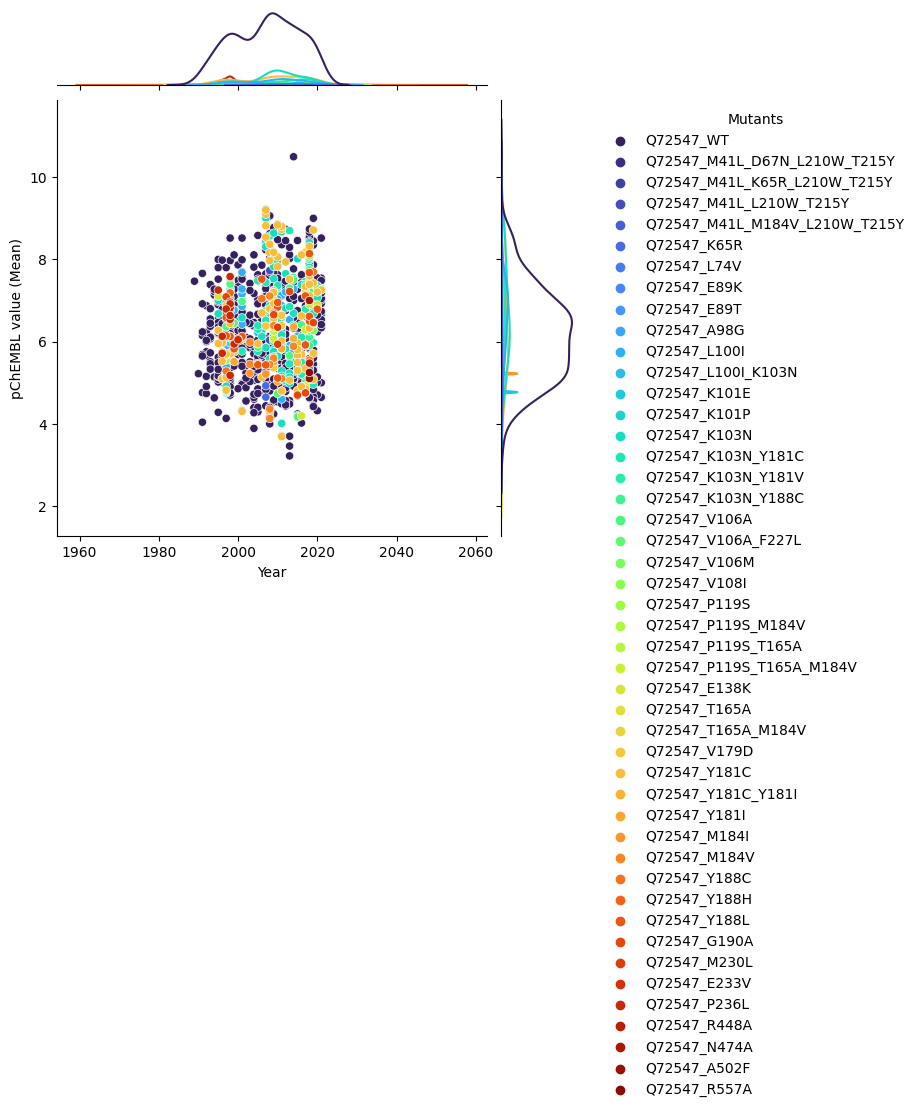

In [118]:
double_density_pchembl_year(accession_data, accession_subset, output_dir, accession, 'annotated_data')

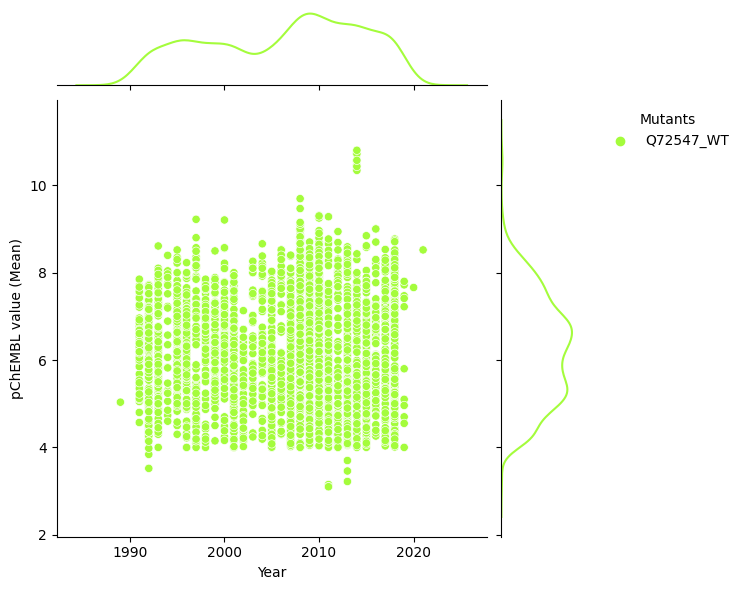

In [119]:
papyrus_accession_subset = papyrus_accession_data['connectivity'].unique().tolist()
double_density_pchembl_year(papyrus_accession_data, papyrus_accession_subset, output_dir, accession, 'papyrus_data')

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\seaborn\axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\seaborn\axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


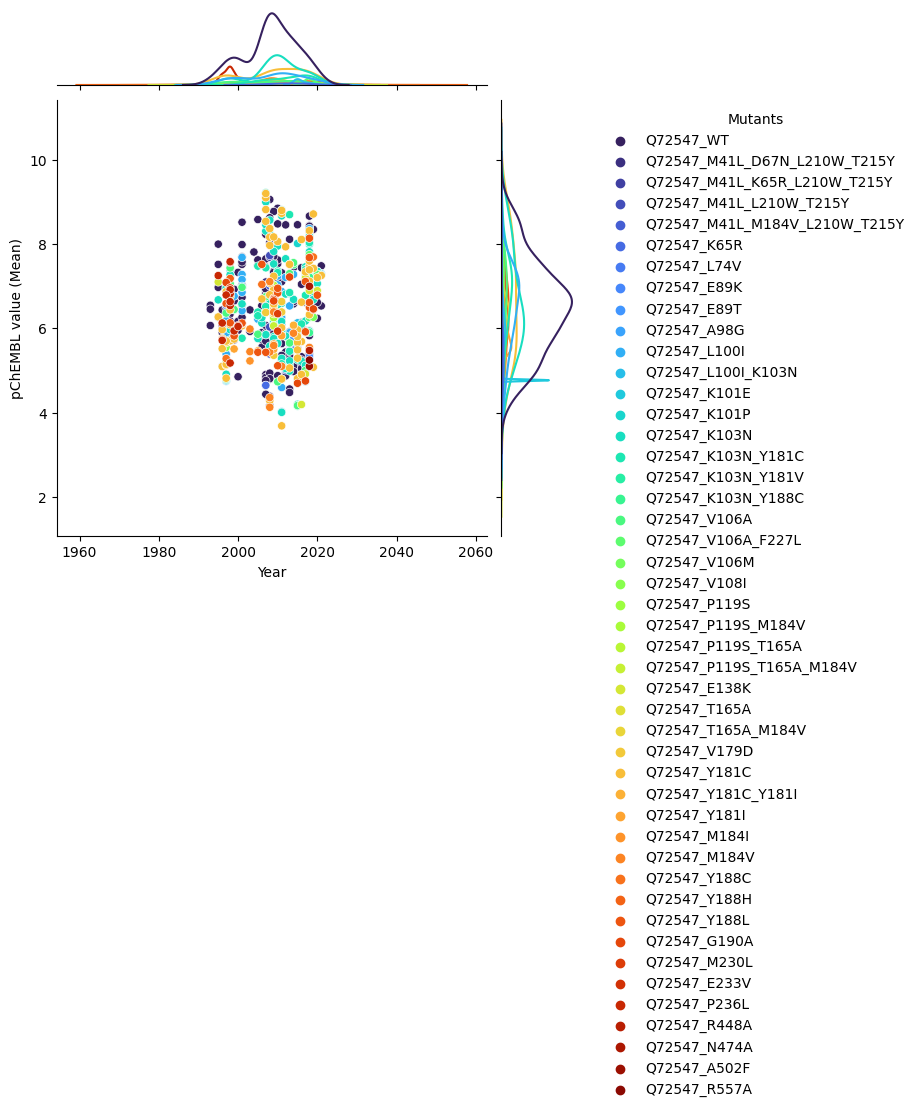

In [120]:
double_density_pchembl_year(accession_data, common_subset, os.path.join(output_dir,preferred_common_subset_dir),
                            accession, 'annotated_common')

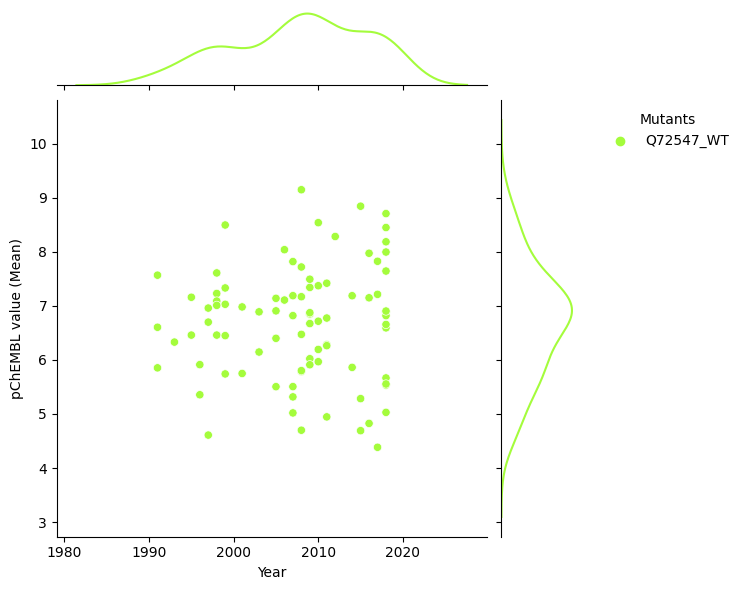

In [121]:
double_density_pchembl_year(papyrus_accession_data, common_subset, os.path.join(output_dir,
                                                                                 preferred_common_subset_dir),
                            accession, 'papyrus_common')

In [122]:
def plot_common_subset_bioactivity_heatmap(clustermap:bool, accession: str, common: bool, sim: bool, sim_thres: int,
                                           threshold: int, variant_coverage: float, output_dir: str):
    """
    Plot heatmap of common subset and clustermap of strictly common subset (without annotations).
    :param clustermap:
    :param accession:
    :param common:
    :param sim:
    :param sim_thres:
    :param threshold:
    :param variant_coverage:
    :param output_dir:
    :return:
    """
    # Read bioactivity data for common subset precalculated
    data_common = read_common_subset(accession, common, sim, sim_thres, threshold, variant_coverage, output_dir)

    # Pivot data to plot heatmap
    heatmap_df = data_common.pivot(index='target_id', columns='connectivity', values='pchembl_value_Mean')

    if not clustermap:
        # Heatmap with full common subset (contains NAs)
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.heatmap(heatmap_df, cmap='mako_r', linewidth=0.1, linecolor='w', square=True,
                    cbar_kws={'label': 'pChEMBL value (Mean)', 'aspect': 0.2})
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'heatmap_{accession}.svg'))
    else:
        # Clustermap with strictly common subset (no NAs)
        sns.clustermap(heatmap_df[heatmap_df.columns[~heatmap_df.isnull().any()]], cmap='mako_r',
                       linewidth=0.1, linecolor='w', cbar_kws={'label': 'pChEMBL value (Mean)'})
        plt.savefig(os.path.join(output_dir, f'clustermap_{accession}.svg'))

    # Return strict common subset
    strict_subset_connectivity = list(heatmap_df[heatmap_df.columns[~heatmap_df.isnull().any()]].columns)
    return strict_subset_connectivity

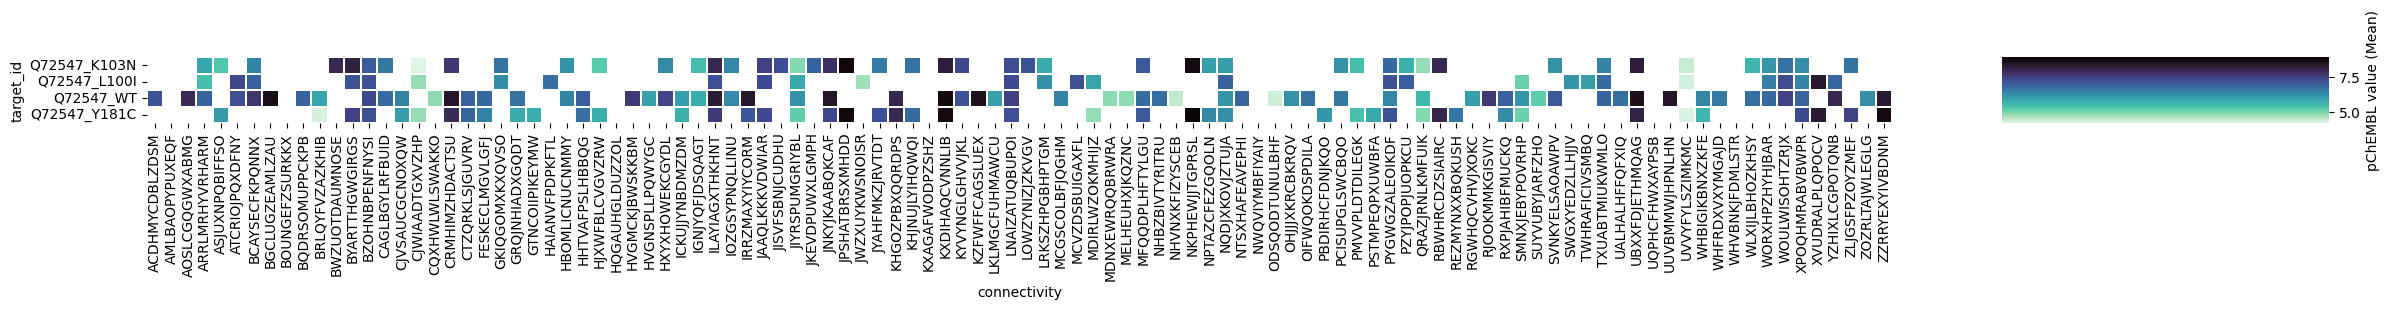

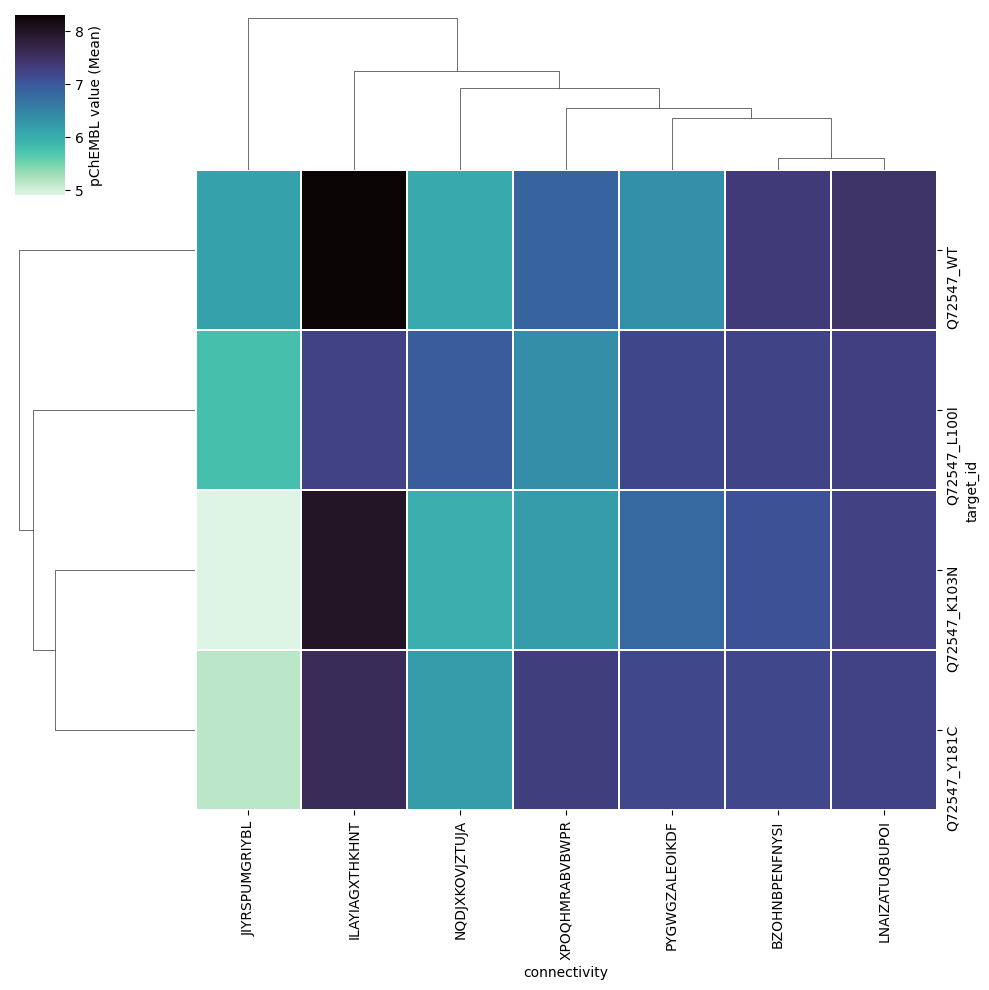

In [123]:
for clustermap in [False, True]:
    strict_subset = plot_common_subset_bioactivity_heatmap(clustermap, accession, common=True, sim=True, sim_thres=0.8, threshold=2,
                                            variant_coverage=0.2, output_dir=os.path.join(output_dir, preferred_common_subset_dir))

In [124]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

def butina_cluster_compounds(accession_data, subset, output_dir, cutoff=0.2):
    """
    Cluster compounds with Butina algorithm.
    :param accession_data:
    :param subset:
    :param cutoff:
    :return:
    """
    subset_df = accession_data[accession_data['connectivity'].isin(subset)]
    # Keep first occurence
    subset_df.drop_duplicates(subset='connectivity', keep='first', inplace=True, ignore_index=True)

    # Compute molecule from smiles
    PandasTools.AddMoleculeColumnToFrame(subset_df,'SMILES','Molecule',includeFingerprints=True)

    # Extract RDkit molecular objects
    mMols = subset_df['Molecule'].tolist()

    compounds = []
    for _, connectivity, mol in subset_df[["connectivity", "Molecule"]].itertuples():
        compounds.append((mol, connectivity))

    # Create fingerprints for all molecules
    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
    fplist = [rdkit_gen.GetFingerprint(mol) for mol in mMols]

    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fplist)

    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fplist), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)

    # Give a short report about the numbers of clusters and their sizes
    num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
    num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
    num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
    num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

    print("total # clusters: ", len(clusters))
    print("# clusters with only 1 compound: ", num_clust_g1)
    print("# clusters with >5 compounds: ", num_clust_g5)
    print("# clusters with >25 compounds: ", num_clust_g25)
    print("# clusters with >100 compounds: ", num_clust_g100)

    # Plot the size of the clusters
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)

    # Save plot
    plt.savefig(os.path.join(output_dir, f'{accession}_common_subset_ButinaClusters_{cutoff}.png'))

    # Make dictionary mapping cluster index to connectivity
    connectivity_cluster_dict = {}
    for i,(mol,connectivity) in enumerate(compounds):
        for j,cluster in enumerate(clusters):
            if i in cluster:
                connectivity_cluster_dict[connectivity] = j + 1 # cluster numbers from 1 on (not zero)

    return clusters,compounds, connectivity_cluster_dict

total # clusters:  4
# clusters with only 1 compound:  3
# clusters with >5 compounds:  0
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


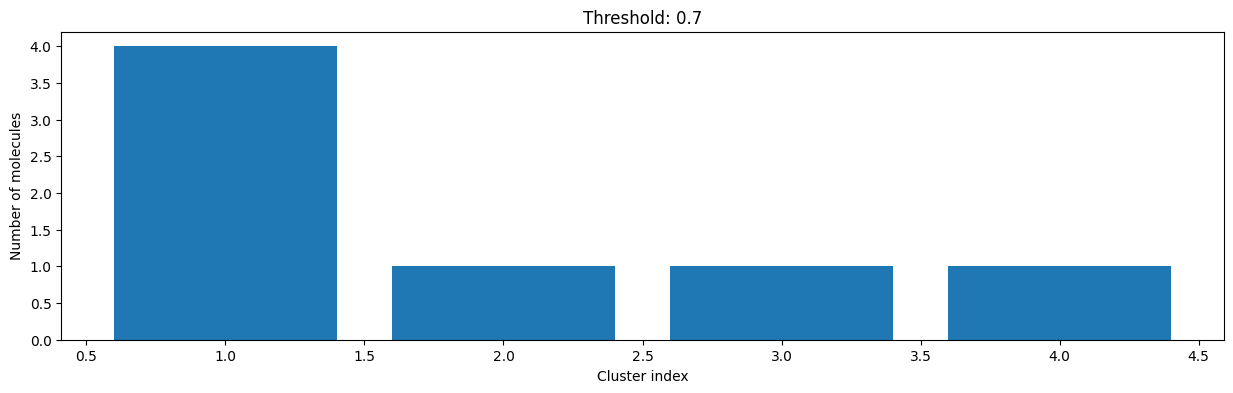

In [125]:
clusters,compounds,connectivity_cluster_dict = butina_cluster_compounds(accession_data, strict_subset, os
                                                                        .path.join(output_dir,preferred_common_subset_dir), 0.7)

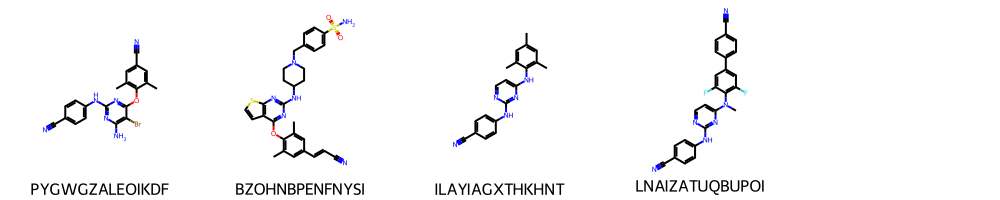

In [126]:
# Visualize molecules in first cluster
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0]],
    legends=[compounds[i][1] for i in clusters[0]],
    molsPerRow=5,
)

In [127]:
def GetRingSystems(mol, includeSpiro=False):
    """
    Extract ring systems in molecule
    :param mol:
    :param includeSpiro:
    :return:
    """
    ri = mol.GetRingInfo()
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems

def visualize_subset(accession_data, subset, match_type, substructure_to_match):
    """
    Define atom numbers to highlight in molecular representation.
    :param accession_data:
    :param subset:
    :param match_type:
    :param substructure_to_match:
    :return:
    """
    subset_df = accession_data[accession_data['connectivity'].isin(subset)]
    # Keep first occurence
    subset_df.drop_duplicates(subset='connectivity', keep='first', inplace=True, ignore_index=True)

    # Compute molecule from smiles
    PandasTools.AddMoleculeColumnToFrame(subset_df,'SMILES','Molecule',includeFingerprints=True)

    # Extract RDkit molecular objects
    mMols = subset_df['Molecule'].tolist()

    if match_type == 'Murcko':
    # Calculate Murcko Scaffold Hashes
        murckoHashList = [rdMolHash.MolHash(mMol, rdkit.Chem.rdMolHash.HashFunction.MurckoScaffold) for mMol in mMols]

        # Get the most frequent Murcko Scaffold Hash
        def mostFreq(list):
            return max(set(list), key=list.count)
        mostFreq_murckoHash = mostFreq(murckoHashList)

        # Display molecules with MurkoHash as legends and highlight the mostFreq_murckoHash
        mostFreq_murckoHash_mol = Chem.MolFromSmiles(mostFreq_murckoHash)
        highlight_match = [mMol.GetSubstructMatch(mostFreq_murckoHash_mol) for mMol in mMols]

    elif match_type == 'MCS':
        mcs = rdFMCS.FindMCS(mMols)
        match_mol = Chem.MolFromSmarts(mcs.smartsString)
        highlight_match = [mMol.GetSubstructMatch(match_mol) for mMol in mMols]

    elif match_type == 'ring':
        # Extract ring systems for each molecule
        ringSys_list = [GetRingSystems(mMol) for mMol in mMols]
        # Keep the biggest ring system for each molecule
        highlight_match = [max(ringSys, key=len) for ringSys in ringSys_list]

    elif match_type == 'SMILES':
        match_mol = Chem.MolFromSmiles(substructure_to_match[match_type])
        highlight_match = [mMol.GetSubstructMatch(match_mol) for mMol in mMols]

    elif match_type == 'SMARTS':
        match_mol = Chem.MolFromSmarts(substructure_to_match[match_type])
        highlight_match = [mMol.GetSubstructMatch(match_mol) for mMol in mMols]


    return mMols, highlight_match

In [128]:
# Define custom substructures to highlight in molecular representations
# (Default is biggest ring system for the whole common subset and maximum common substructure within a cluster for
# each Butina cluster)
substructure_match_dict = {'P00533':{'SMILES':'CNc1ncnc2ccccc12',
                                     'SMARTS':'a1aaaaa1'},
                           'P00519':{'SMILES':'COc1ncnc2ccccc12',
                                     'SMARTS':'a1aaaaa1Na1aaaaa1'},
                           'P36888':{},
                           'Q72547':{}
                           }

In [129]:
# Plot strictly common subset, highlighting the biggest ring in each molecule for easier comparison
mMols, highlight_match = visualize_subset(accession_data, strict_subset, 'ring',
                                                 substructure_match_dict[accession])
img = Draw.MolsToGridImage(mMols,legends=strict_subset,
                     highlightAtomLists = highlight_match,
                     subImgSize=(500,500), useSVG=False, molsPerRow=5, returnPNG=False)
img.save(os.path.join(output_dir, preferred_common_subset_dir, f'{accession}_strictly_common_subset_highlight_ring.png'))

In [131]:
# Plot clusters 1 and 2 of strictly common subset, highlighting the MCS in each cluster
for cluster in [1,2]:
    cluster_connectivities = [k for k, v in connectivity_cluster_dict.items() if v == cluster]
    mMols, highlight_match = visualize_subset(accession_data, cluster_connectivities, 'MCS',
                                             substructure_match_dict[accession])
    img = Draw.MolsToGridImage(mMols,legends=cluster_connectivities,
                         highlightAtomLists = highlight_match,
                         subImgSize=(500,500), useSVG=False, molsPerRow=5, returnPNG=False)
    img.save(os.path.join(output_dir, preferred_common_subset_dir,
                          f'{accession}_strictly_common_subset_cluster{cluster}_highlightMCS.png'))

In [132]:
def plot_strict_subset_bioactivity_clustermap_ButinaCluster_groups(accession_data, accession: str,
                                                                   connectivity_cluster_dict,
                                                                   common: bool, sim: bool,sim_thres: int, threshold:
        int, variant_coverage: float, output_dir: str):
    """
    Plot clustermap of accession's strictly common subset with molecule annotations based on their cluster number
    (Butina Cluster)
    :param accession_data:
    :param accession:
    :param connectivity_cluster_dict:
    :param common:
    :param sim:
    :param sim_thres:
    :param threshold:
    :param variant_coverage:
    :param output_dir:
    :return:
    """
    # Read bioactivity data for common subset precalculated
    data_accession = pd.read_csv(os.path.join(output_dir, f'modelling_dataset_{accession}_Thr{threshold}_Cov'
                                                          f'{int(variant_coverage*100)}_Sim'
                                                          f'{int(sim_thres*100)}.csv'), sep='\t')

    # Pivot data to plot heatmap
    heatmap_df = data_accession.pivot(index='target_id', columns='connectivity', values='pchembl_value_Mean')

    # Keep df with strictly common subset
    strict_subset_df = heatmap_df[heatmap_df.columns[~heatmap_df.isnull().any()]]

    # Map strictly common subset to its butina cluster
    strict_subset_cluster = [connectivity_cluster_dict[connectivity] for connectivity in strict_subset_df.columns]

    # Assign a color to each possible cluster
    clusters = sorted(list(set(connectivity_cluster_dict.values())))
    cluster_colors = mcp.gen_color(cmap='flare', n=len(clusters))
    cluster_color_dict = dict(zip(clusters, cluster_colors))

    # Map each molecule in the strictly common subset to its color based on the Butina cluster
    strict_subset_color = [cluster_color_dict[cluster] for cluster in strict_subset_cluster]

    # Clustermap with exclusively common subset (no NAs)
    sns.clustermap(strict_subset_df, cmap='mako_r',
                   linewidth=0.1, linecolor='w', cbar_kws={'label': 'pChEMBL value (Mean)'},
                   col_colors=strict_subset_color)

    # Add legend of year-based color of molecules
    strict_subset_cluster_color_dict = dict(sorted(zip(strict_subset_cluster, strict_subset_color)))
    handles = [Patch(facecolor=color) for color in strict_subset_cluster_color_dict.values()]
    labels = strict_subset_cluster_color_dict.keys()

    plt.legend(handles, labels, title='Butina cluster',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    # save figure
    plt.savefig(os.path.join(output_dir, f'clustermap_{accession}_ButinaCluster_groups.svg'))

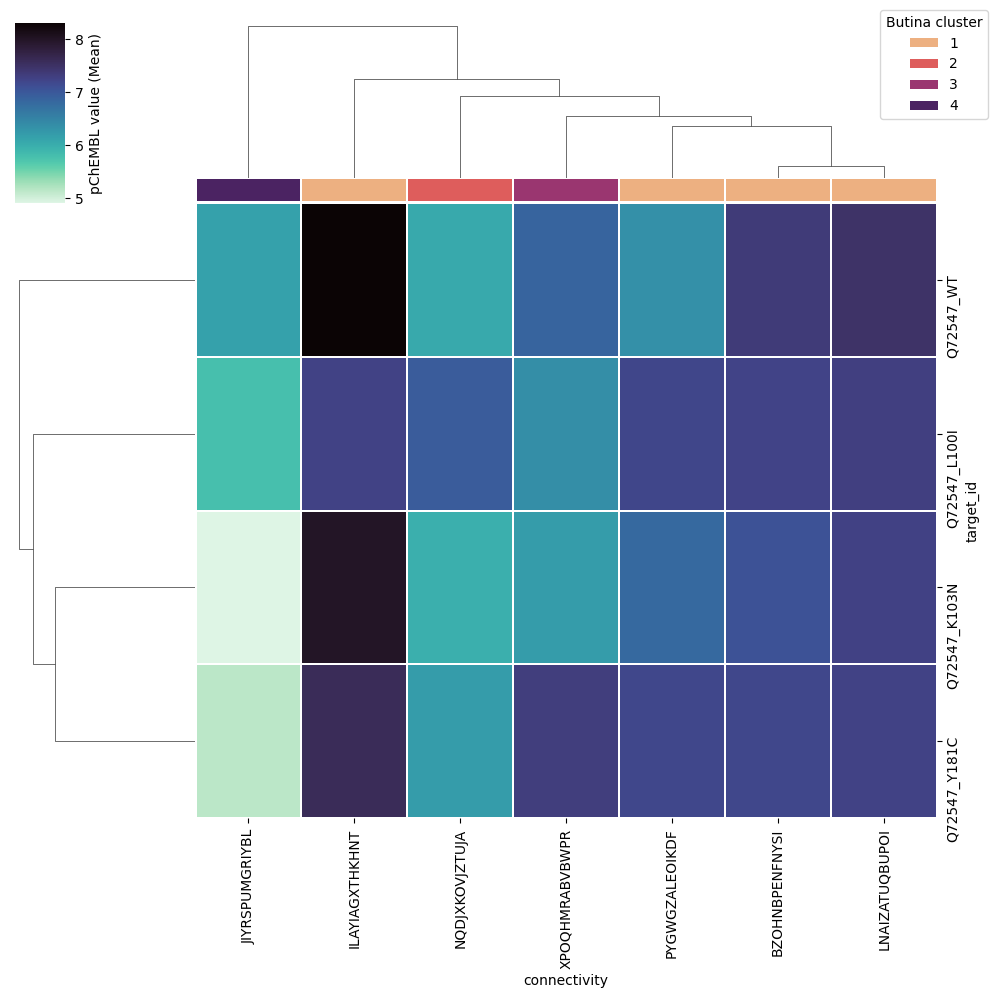

In [133]:
plot_strict_subset_bioactivity_clustermap_ButinaCluster_groups(accession_data, accession, connectivity_cluster_dict,
                                                       common=True, sim=True,
                                                      sim_thres=0.8,threshold=2,variant_coverage=0.2, output_dir=os.path.join(output_dir,
                                                                                      preferred_common_subset_dir))

In [134]:
def keep_oldest_data(data):
    data = data.dropna(axis=0, subset=['Year'])
    data_oldest = data.groupby('connectivity', group_keys=False).apply(lambda x: x.loc[x.Year.idxmin()])
    return data_oldest

In [135]:
def plot_strict_subset_bioactivity_clustermap_year_groups(accession_data, accession: str, common: bool, sim: bool,
                                                     sim_thres: int, threshold: int, variant_coverage: float,
                                                     output_dir: str):
    """
    Plot clustermap of accession's strictly common subset with molecule annotations based on the Year of first
    publication.
    :param accession_data:
    :param accession:
    :param common:
    :param sim:
    :param sim_thres:
    :param threshold:
    :param variant_coverage:
    :param output_dir:
    :return:
    """
    # Read bioactivity data for common subset precalculated
    data_accession = pd.read_csv(os.path.join(output_dir, f'modelling_dataset_{accession}_Thr{threshold}_Cov'
                                                          f'{int(variant_coverage*100)}_Sim'
                                                          f'{int(sim_thres*100)}.csv'), sep='\t')

    # Keep oldest Year for every compound
    accession_data = keep_oldest_data(accession_data)

    # Pivot data to plot heatmap
    heatmap_df = data_accession.pivot(index='target_id', columns='connectivity', values='pchembl_value_Mean')

    # Keep df with strictly common subset
    strict_subset_df = heatmap_df[heatmap_df.columns[~heatmap_df.isnull().any()]]

    # Extract years of publication for strictly common subset
    connectivity_to_year_dict = dict(zip(accession_data.connectivity, accession_data.Year))
    strict_subset_year = [int(connectivity_to_year_dict[connectivity]) if (connectivity in connectivity_to_year_dict
                                                                        .keys())
                          else 0 for connectivity in strict_subset_df.columns ]
    print(strict_subset_year)
    # Assign a color to each possible year in the full accession bioactivity set
    # year_range = list(range(int(min(connectivity_to_year_dict.values())), int(max(connectivity_to_year_dict.values()))
    #                        , 1))
    year_range = list(range(min(strict_subset_year), max(strict_subset_year) + 1,1))
    year_colors = mcp.gen_color(cmap='flare', n=len(year_range))
    year_color_dict = dict(zip(year_range, year_colors))
    year_color_dict[0] = '#FFFFFF' # Missing year is white

    # Map each molecule in the strictly common subset to its color based on the publication year
    strict_subset_color = [year_color_dict[int(year)] for year in strict_subset_year]

    # # Clustermap with NAs replaced by zero
    # sns.clustermap(heatmap_df.fillna(0), cmap='mako_r',
    #                linewidth=0.1, linecolor='w', cbar_kws={'label': 'pChEMBL value (Mean)'},
    #                col_colors=strict_subset_color)

    # Clustermap with exclusively common subset (no NAs)
    sns.clustermap(strict_subset_df, cmap='mako_r',
                   linewidth=0.1, linecolor='w', cbar_kws={'label': 'pChEMBL value (Mean)'},
                   col_colors=strict_subset_color)

    # Add legend of year-based color of molecules
    strict_subset_year_color_dict = dict(sorted(zip(strict_subset_year, strict_subset_color)))
    handles = [Patch(facecolor=color) for color in strict_subset_year_color_dict.values()]
    labels = strict_subset_year_color_dict.keys()

    plt.legend(handles, labels, title='Year',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    # save figure
    plt.savefig(os.path.join(output_dir, f'clustermap_{accession}_year_groups.svg'))

[2020, 2018, 1997, 2021, 1993, 2009, 2000]


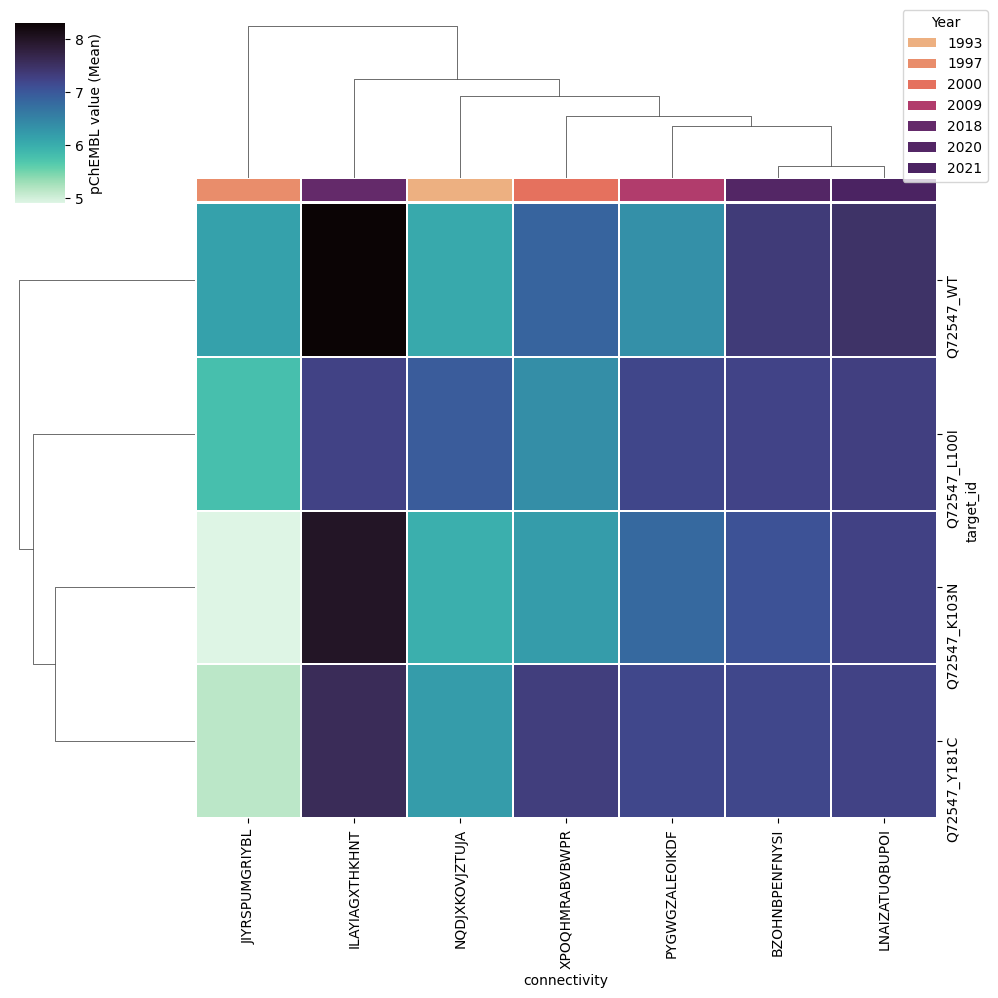

In [136]:
plot_strict_subset_bioactivity_clustermap_year_groups(accession_data, accession, common=True, sim=True,
                                                      sim_thres=0.8,threshold=2,variant_coverage=0.2, output_dir=os.path.join(output_dir,
                                                                                      preferred_common_subset_dir))

### NOTE: Using Papyrus data Years were correct, using ChEMBL extracted data we are only considering the oldest for
# this particular accession. (Years do not match with Papyrus)

In [137]:
# Next idea: color mutants based on distance from mutated residue to center of mass of ligand (calculated in Pymol),
# or closest distance to ligand

# Also, mutants can be colored based on the year of the first assay on them. This will show "when" (approximately)
# they emerged into public knowledge/relevance compared to other mutants

In [138]:
# Pre-calculate average distance to ligand for every residue in the protein
calculate_average_residue_distance_to_ligand(accession=accession,
                                             resn=[],
                                             common=False,
                                             pdb_dir=os.path.join(output_dir,'1_common_subset', 'PDB'),
                                             output_dir=os.path.join(output_dir,'1_common_subset'))

Fetched: 2 / 2


{'1': 26.398,
 '2': 28.465,
 '3': 26.002,
 '4': 28.065,
 '5': 26.236,
 '6': 29.256,
 '7': 30.737,
 '8': 29.01,
 '9': 32.306,
 '10': 32.799,
 '11': 36.357,
 '12': 38.087,
 '13': 37.371,
 '14': 40.962,
 '15': 43.979,
 '16': 42.02,
 '17': 43.644,
 '18': 42.048,
 '19': 41.058,
 '20': 45.518,
 '21': 43.31,
 '22': 47.229,
 '23': 44.424,
 '24': 44.472,
 '25': 47.968,
 '26': 44.793,
 '27': 45.915,
 '28': 49.063,
 '29': 44.011,
 '30': 41.852,
 '31': 44.53,
 '32': 44.027,
 '33': 39.684,
 '34': 39.172,
 '35': 41.748,
 '36': 38.819,
 '37': 35.521,
 '38': 37.551,
 '39': 39.208,
 '40': 34.828,
 '41': 33.383,
 '42': 38.377,
 '43': 36.549,
 '44': 32.184,
 '45': 33.649,
 '46': 30.877,
 '47': 35.561,
 '48': 38.856,
 '49': 43.24,
 '50': 44.053,
 '51': 47.373,
 '52': 50.287,
 '53': 50.23,
 '54': 45.101,
 '55': 46.765,
 '56': 43.474,
 '57': 42.485,
 '58': 38.736,
 '59': 39.415,
 '60': 38.763,
 '61': 38.014,
 '62': 37.221,
 '63': 35.001,
 '64': 36.339,
 '65': 35.639,
 '66': 35.076,
 '67': 32.942,
 '68': 33.

<>:90: DeprecationWarning: invalid escape sequence \A
<>:90: DeprecationWarning: invalid escape sequence \A
<>:90: DeprecationWarning: invalid escape sequence \A
C:\Users\gorostiolam\AppData\Local\Temp\ipykernel_12100\352064620.py:90: DeprecationWarning: invalid escape sequence \A
  cb.set_label("Average distance of mutated residue\nCOG to ligand COG ($\AA$)", size=10, labelpad=10)


Reading pre-computed results...
{'2JLE': {'ligand': 'I15', 'chain': 'A', 'distance': {'1': 26.398, '2': 28.465, '3': 26.002, '4': 28.065, '5': 26.236, '6': 29.256, '7': 30.737, '8': 29.01, '9': 32.306, '10': 32.799, '11': 36.357, '12': 38.087, '13': 37.371, '14': 40.962, '15': 43.979, '16': 42.02, '17': 43.644, '18': 42.048, '19': 41.058, '20': 45.518, '21': 43.31, '22': 47.229, '23': 44.424, '24': 44.472, '25': 47.968, '26': 44.793, '27': 45.915, '28': 49.063, '29': 44.011, '30': 41.852, '31': 44.53, '32': 44.027, '33': 39.684, '34': 39.172, '35': 41.748, '36': 38.819, '37': 35.521, '38': 37.551, '39': 39.208, '40': 34.828, '41': 33.383, '42': 38.377, '43': 36.549, '44': 32.184, '45': 33.649, '46': 30.877, '47': 35.561, '48': 38.856, '49': 43.24, '50': 44.053, '51': 47.373, '52': 50.287, '53': 50.23, '54': 45.101, '55': 46.765, '56': 43.474, '57': 42.485, '58': 38.736, '59': 39.415, '60': 38.763, '61': 38.014, '62': 37.221, '63': 35.001, '64': 36.339, '65': 35.639, '66': 35.076, '67':

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\ipykernel_launcher.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


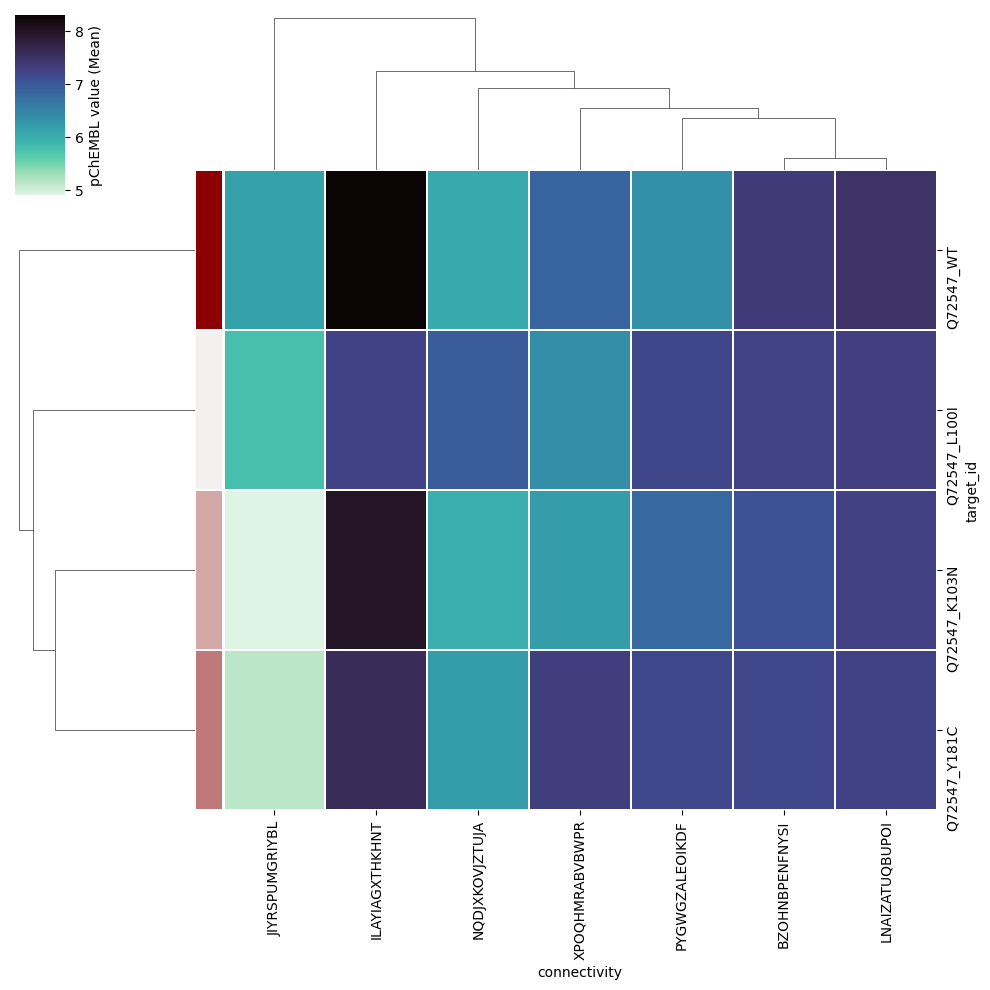

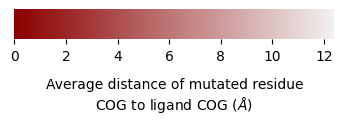

In [139]:
def plot_strict_subset_bioactivity_clustermap_distance_groups(accession_data, accession: str, common: bool, sim: bool,
                                                              sim_thres: int, threshold: int, variant_coverage: float,
                                                              dist_dir: str, output_dir: str):
    """
    Plot clustermap of accession's strictly common subset with variant annotations based on the distance from the
    mutated residue to the ligand (average between centers of geometry of all possible structures with co-crystalzied
     ligand).
    :param accession_data:
    :param accession:
    :param common:
    :param sim:
    :param sim_thres:
    :param threshold:
    :param variant_coverage:
    :param dist_dir:
    :param output_dir:
    :return:
    """
    # Read bioactivity data for common subset precalculated
    data_accession = pd.read_csv(os.path.join(output_dir, f'modelling_dataset_{accession}_Thr{threshold}_Cov'
                                                          f'{int(variant_coverage*100)}_Sim'
                                                          f'{int(sim_thres*100)}.csv'), sep='\t')

    # Pivot data to plot heatmap
    heatmap_df = data_accession.pivot(index='target_id', columns='connectivity', values='pchembl_value_Mean')

    # Keep df with strictly common subset
    strict_subset_df = heatmap_df[heatmap_df.columns[~heatmap_df.isnull().any()]]

    # Calculate distance to ligand from mutated residues
    mutants_resn = [int(target_id.split('_')[1][1:-1]) if 'WT' not in target_id else 'WT' for target_id in
                    strict_subset_df.index.tolist()]
    distances_dict = calculate_average_residue_distance_to_ligand(accession=accession,
                                             resn=mutants_resn,
                                             common=False,
                                             pdb_dir=os.path.join(dist_dir,'PDB'),
                                             output_dir=dist_dir)
    # Map distances to mutants
    mutants_dist = [distances_dict[str(res)] if res != 'WT' else 0 for res in mutants_resn]

    # Create color map based on distances
    # Colors
    # COLORS = sns.color_palette("YlOrBr",as_cmap=False)
    COLORS = sns.light_palette("darkred", reverse=True,  as_cmap=False)

    # Colormap
    from matplotlib import colors
    from math import floor
    from matplotlib.cm import ScalarMappable
    cmap = colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

    # Normalizer
    def round_half_up(n, decimals=0):
        multiplier = 10 ** decimals

        return floor(n*multiplier + 0.5) / multiplier
    norm = colors.Normalize(vmin=floor(min(mutants_dist)), vmax=round_half_up(max(mutants_dist),1))

    # Normalized colors. Each number of tracks is mapped to a color in the
    # color scale 'cmap'
    COLORS = cmap(norm(mutants_dist))

    # # Clustermap with NAs replaced by zero
    # sns.clustermap(heatmap_df.fillna(0), cmap='mako_r',
    #                linewidth=0.1, linecolor='w', cbar_kws={'label': 'pChEMBL value (Mean)'},
    #                col_colors=strict_subset_color)

    # Clustermap with exclusively common subset (no NAs)
    sns.clustermap(strict_subset_df, cmap='mako_r',
                   linewidth=0.1, linecolor='w', cbar_kws={'label': 'pChEMBL value (Mean)'},
                       row_colors=COLORS)
    # save figure
    plt.savefig(os.path.join(output_dir, f'clustermap_{accession}_distance_groups.svg'))

    # Create the colorbar
    import pylab as pl
    pl.figure(figsize=(4, 0.5))
    cax = pl.axes([0.1, 0.2, 0.8, 0.6])

    cb = pl.colorbar(
        ScalarMappable(norm=norm, cmap=cmap),
        orientation = "horizontal",
        cax=cax
    )

    # Remove the outline of the colorbar
    cb.outline.set_visible(False)

    # Set legend label and move it to the top (instead of default bottom)
    cb.set_label("Average distance of mutated residue\nCOG to ligand COG ($\AA$)", size=10, labelpad=10)

    plt.tight_layout()
    # save figure
    plt.savefig(os.path.join(output_dir, f'clustermap_{accession}_distance_groups_legend.svg'))




plot_strict_subset_bioactivity_clustermap_distance_groups(accession_data, accession, common=True, sim=True,
                                                      sim_thres=0.8,threshold=2,variant_coverage=0.2,
                                                          dist_dir = os.path.join(output_dir,'1_common_subset'),
                                                          output_dir=os.path.join(output_dir,preferred_common_subset_dir))